In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X_train = np.genfromtxt('X_train.txt')
y_train = np.genfromtxt('y_train.txt')

X_test = np.genfromtxt('X_test.txt')
y_test = np.genfromtxt('y_test.txt')

with open('activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [3]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [4]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


In [15]:
try: 
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic_s20/homeworks_basic/Lab2_boosting/unique_columns.txt -nc
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)

X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

## I'll start with random forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

In [15]:
rf = RandomForestClassifier(n_estimators=30, n_jobs=-2, random_state=226, oob_score=True)

In [21]:
rf.fit(X_train_unique, y_train)
print('accuracy = {}'.format(accuracy_score(y_test, rf.predict(X_test_unique))))

accuracy = 0.9304377332880895


In [22]:
#searching for best params
params = {
    'n_estimators': np.arange(150, 501, 50),
    'max_depth': [5,6,7],
    'min_samples_split': [4, 8, 12, 16],
    'min_samples_leaf': [2, 4, 6, 8],
}
best_rf = RandomizedSearchCV(rf, params, cv=5, n_jobs=-2, n_iter = 30)
best_rf.fit(X_train_unique, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [23]:
pprint(best_rf.best_params_)
print('accuracy = {}'.format(accuracy_score(y_test, best_rf.predict(X_test_unique))))


{'max_depth': 7,
 'min_samples_leaf': 8,
 'min_samples_split': 16,
 'n_estimators': 150}
accuracy = 0.9148286392941974


## XGBoost

In [6]:
from xgboost import XGBClassifier
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt

In [30]:
xgbtree = XGBClassifier(booster='gbtree',  n_jobs=-2, random_state=227)
params = {
    'max_depth': np.arange(2, 13, 2),
    'learning_rate': np.linspace(0.1, 0.9, 9),
    'gamma': np.linspace(0.1, 0.6, 6),
    'n_estimators': np.arange(150, 401, 50),
}
best_xgbtree = RandomizedSearchCV(xgbtree, params, cv=5, n_jobs=-2)

In [31]:
xgbtree_result = best_xgbtree.fit(X_train_unique, y_train)

In [34]:
print('best tree parameters:')
print(xgbtree_result.best_params_)

best tree parameters:
{'gamma': 0.4, 'learning_rate': 0.5, 'max_depth': 2, 'n_estimators': 400}


In [38]:
xgbtree_ = XGBClassifier(booster='gbtree', **xgbtree_result.best_params_, n_jobs=-2, random_state=227)

In [39]:
xgbtree_.fit(X_train_unique, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=-2, num_parallel_tree=1,
              objective='multi:softprob', random_state=227, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
accuracy_score(y_test, xgbtree_.predict(X_test_unique))

0.9440108585001696

### got 94% !

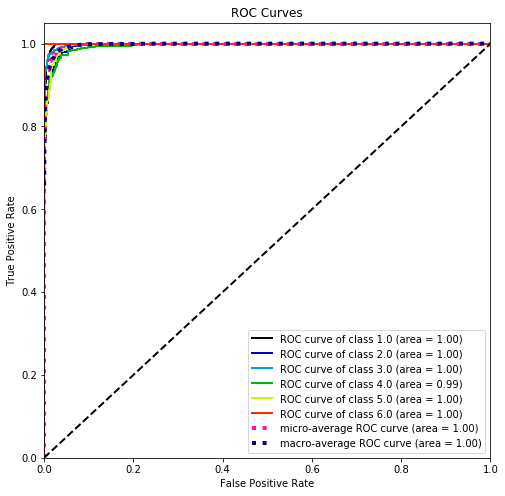

In [26]:
plot_roc(y_test, xgbtree_.predict_proba(X_test_unique), figsize=(8, 8))
plt.show()

## try lightGbm now

In [8]:
import lightgbm as lgbm

In [58]:
lgbm_clf = lgbm.LGBMClassifier(boosting_type='gbdt',  num_leaves=50, n_estimators=10, random_state=227)
lgbm_params = {
    'num_leaves': np.arange(30, 50, 2),
    'n_estimators': np.arange(50, 401, 50),
    'learning_rate': np.linspace(0.1, 0.9, 9)
}
best_lgbm_clf = RandomizedSearchCV(lgbm_clf, lgbm_params, cv=5, n_jobs=-2, random_state=243, verbose=10, n_iter = 10)

In [59]:
lgbm_result = best_lgbm_clf.fit(X_train_unique, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-2)]: Done  35 out of  50 | elapsed:  5.1min remaining:  2.2min
[Parallel(n_jobs=-2)]: Done  41 out of  50 | elapsed:  5.9min remaining:  1.3min
[Parallel(n_jobs=-2)]: Done  47 out of  50 | elapsed:  6.2min remaining:   23.6s
[Parallel(n_jobs=-2)]: Done  50 out of  50 | elapsed:  6.4min finished


In [60]:
print('best lgbm classifier parameters:')
pprint(lgbm_result.best_params_)

best lgbm classifier parameters:
{'learning_rate': 0.7000000000000001, 'n_estimators': 400, 'num_leaves': 44}


In [61]:
light_gbm_best = lgbm.LGBMClassifier(boosting_type='gbdt',  **lgbm_result.best_params_ , random_state=227, n_jobs=-2)

In [62]:
light_gbm_best.fit(X_train_unique, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.7000000000000001,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=400, n_jobs=-2, num_leaves=44,
               objective=None, random_state=227, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [63]:
accuracy_score(y_test,light_gbm_best.predict(X_test_unique))

0.9358669833729216

### 93.6%  a bit worse than XGboost

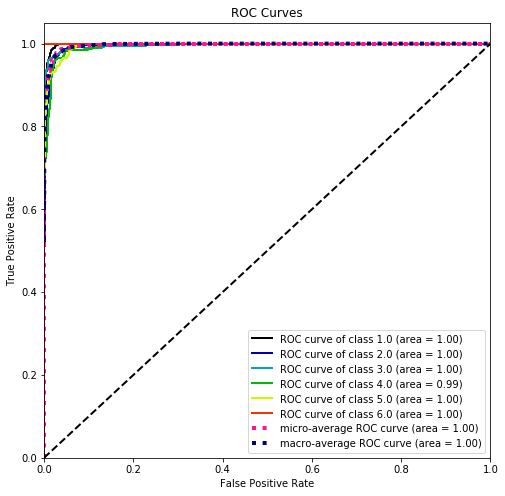

In [66]:
plot_roc(y_test, light_gbm_best.predict_proba(X_test_unique), figsize=(8, 8))
plt.show()